In [1]:
from sklearn.datasets import fetch_20newsgroups
import matplotlib.pyplot as plt

import numpy as np
np.random.seed(42)
import random
random.seed(42)

# Question 1: Histogram of Training Documents

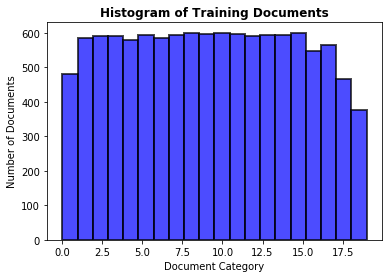

In [2]:
newsgroups = fetch_20newsgroups(subset = 'train')

plt.hist(newsgroups.target, bins=20, facecolor='blue', alpha = 0.7, edgecolor='black', linewidth=2)
plt.xlabel('Document Category')
plt.ylabel('Number of Documents')
plt.title('Histogram of Training Documents', fontweight='bold')
plt.show()
# plt.savefig('hist.png')

# Question 2: Feature Extraction

In [3]:
categories = ['comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware',
'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey']

train_dataset = fetch_20newsgroups(subset = 'train', categories = categories, shuffle = True, random_state = None)
test_dataset = fetch_20newsgroups(subset = 'test', categories = categories, shuffle = True, random_state = None)

In [4]:
import nltk
# nltk.download('punkt')
# nltk.download('averaged_perceptron_tagger')

from nltk import pos_tag
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer

from nltk.corpus import wordnet as wn
from collections import defaultdict

# pos_tags: treebank to wordnet
tag_map = defaultdict(lambda: wn.NOUN)
tag_map['J'] = wn.ADJ
tag_map['V'] = wn.VERB
tag_map['R'] = wn.ADV

wnl = WordNetLemmatizer()

    
def lemmatize(data):
    lemmatized = []
    for doc in data:
        tokens = word_tokenize(doc)
        words = [wnl.lemmatize(word, tag_map[tag[0]]) for word,tag in pos_tag(tokens) 
                 if wnl.lemmatize(word, tag_map[tag[0]]).isalpha()]
        sentence = ' '.join(words)
        lemmatized.append(sentence)
    return lemmatized

In [5]:
train_dataset_lemmatized = lemmatize(train_dataset.data)
test_dataset_lemmatized = lemmatize(test_dataset.data)

In [6]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

vectorizer = CountVectorizer(stop_words = 'english', min_df = 3)
X_train_counts = vectorizer.fit_transform(train_dataset_lemmatized)
X_test_counts = vectorizer.transform(test_dataset_lemmatized)

tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_test_tfidf = tfidf_transformer.transform(X_test_counts)

In [7]:
print(X_train_counts.shape, X_test_counts.shape)

(4732, 12609) (3150, 12609)


# Question 3: Dimensionality Reduction

In [8]:
# Latent Semantic Indexing
from sklearn.decomposition import TruncatedSVD

lsi = TruncatedSVD(n_components = 50)
X_train_LSI = lsi.fit_transform(X_train_tfidf)
X_test_LSI = lsi.transform(X_test_tfidf)

USigmaVt = lsi.inverse_transform(X_train_LSI)
LSI_frobenius = np.sum(np.array(X_train_tfidf - USigmaVt)**2)
print("Squared Frobenius Norm for LSI: " + str(LSI_frobenius))

Squared Frobenius Norm for LSI: 4119.824220509407


In [9]:
# Non-negativee Matrix Factorization
from sklearn.decomposition import NMF

nmf = NMF(n_components=50)
X_train_NMF = nmf.fit_transform(X_train_tfidf)
X_test_NMF = nmf.transform(X_test_tfidf)

WH = np.dot(X_train_NMF, nmf.components_)
NMF_frobenius = np.sum(np.array(X_train_tfidf - WH)**2)
print("Squared Frobenius Norm for NMF: " + str(NMF_frobenius))

Squared Frobenius Norm for NMF: 4156.018442876232


# Question 4: Classification Algorithms SVM

In [10]:
# convert to binary classes
Y_train_binary = np.zeros(train_dataset.target.shape)
Y_test_binary = np.zeros(test_dataset.target.shape)

Y_train_binary[train_dataset.target > 3] = 1
Y_test_binary[test_dataset.target > 3] = 1

In [11]:
from sklearn.svm import SVC

svm_hard = SVC(C=1000, kernel='linear')
svm_soft = SVC(C=0.0001, kernel='linear')

svm_hard.fit(X_train_LSI, Y_train_binary)
svm_soft.fit(X_train_LSI, Y_train_binary)

Y_test_prob_hard = svm_hard.decision_function(X_test_LSI)
Y_test_label_hard = svm_hard.predict(X_test_LSI)
Y_test_prob_soft = svm_soft.decision_function(X_test_LSI)
Y_test_label_soft = svm_soft.predict(X_test_LSI)

In [12]:
from sklearn.metrics import roc_curve

fpr_hard, tpr_hard, _ = roc_curve(Y_test_binary, Y_test_prob_hard)
fpr_soft, tpr_soft, _ = roc_curve(Y_test_binary, Y_test_prob_soft)

In [13]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score

print('Hard Margin Linear SVMs:')
print('confusion_matrix:\n', confusion_matrix(Y_test_binary, Y_test_label_hard))
print('accuracy:', accuracy_score(Y_test_binary, Y_test_label_hard))
print('recall:', recall_score(Y_test_binary, Y_test_label_hard))
print('precision:', precision_score(Y_test_binary, Y_test_label_hard))
print('f1_score:', f1_score(Y_test_binary, Y_test_label_hard))
print('\n')
print('Soft Margin Linear SVMs:')
print('confusion_matrix:\n', confusion_matrix(Y_test_binary, Y_test_label_soft))
print('accuracy:', accuracy_score(Y_test_binary, Y_test_label_soft))
print('recall:', recall_score(Y_test_binary, Y_test_label_soft))
print('precision:', precision_score(Y_test_binary, Y_test_label_soft))
print('f1_score:', f1_score(Y_test_binary, Y_test_label_soft))

Hard Margin Linear SVMs:
confusion_matrix:
 [[1509   51]
 [  29 1561]]
accuracy: 0.9746031746031746
recall: 0.9817610062893082
precision: 0.9683622828784119
f1_score: 0.9750156152404746


Soft Margin Linear SVMs:
confusion_matrix:
 [[   0 1560]
 [   0 1590]]
accuracy: 0.5047619047619047
recall: 1.0
precision: 0.5047619047619047
f1_score: 0.6708860759493671


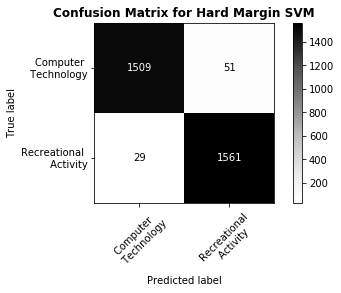

In [14]:
from sklearn.metrics import plot_confusion_matrix

class_names = ['Computer \n Technology', 'Recreational \n Activity']

plot_confusion_matrix(svm_hard, X_test_LSI, Y_test_binary, display_labels=class_names, 
                             values_format='d', xticks_rotation=45, cmap=plt.cm.Greys)
plt.tight_layout()
plt.title('Confusion Matrix for Hard Margin SVM', fontweight='bold')
plt.show()
# plt.savefig('cm_hard.png')

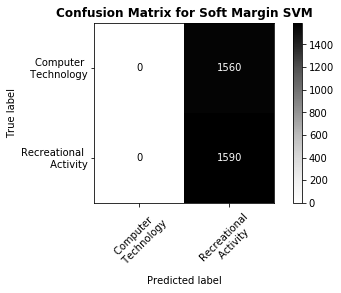

In [15]:
plot_confusion_matrix(svm_soft, X_test_LSI, Y_test_binary, display_labels=class_names, 
                             values_format='d', xticks_rotation=45, cmap=plt.cm.Greys)
plt.tight_layout()
plt.title('Confusion Matrix for Soft Margin SVM', fontweight='bold')
plt.show()
# plt.savefig('cm_soft.png')

In [16]:
# Cross Validation
from sklearn.model_selection import GridSearchCV

svm_cv = GridSearchCV(estimator=SVC(kernel='linear', probability=True), 
                      param_grid={'C':[10**-3,10**-2,10**-1,10**0,10**1,10**2,10**3]}, cv=5)

svm_cv.fit(X_train_LSI, Y_train_binary)

GridSearchCV(cv=5, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='linear', max_iter=-1,
                           probability=True, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [17]:
import pandas as pd

pd.DataFrame(svm_cv.cv_results_)[['param_C','mean_test_score']]

,param_C,mean_test_score
0,0.001,0.504861
1,0.01,0.507608
2,0.1,0.962806
3,1,0.973583
4,10,0.978444
5,100,0.979289
6,1000,0.978866


In [18]:
svm_best = SVC(C=svm_cv.best_params_['C'], kernel='linear')
svm_best.fit(X_train_LSI, Y_train_binary)

Y_test_label_best = svm_best.predict(X_test_LSI)
Y_test_prob_best = svm_best.decision_function(X_test_LSI)

print('Best Linear SVMs:')
print('confusion_matrix:\n', confusion_matrix(Y_test_binary, Y_test_label_best))
print('accuracy:', accuracy_score(Y_test_binary, Y_test_label_best))
print('recall:', recall_score(Y_test_binary, Y_test_label_best))
print('precision:', precision_score(Y_test_binary, Y_test_label_best))
print('f1_score:', f1_score(Y_test_binary, Y_test_label_best))

Best Linear SVMs:
confusion_matrix:
 [[1507   53]
 [  30 1560]]
accuracy: 0.9736507936507937
recall: 0.9811320754716981
precision: 0.9671419714817111
f1_score: 0.974086793630971


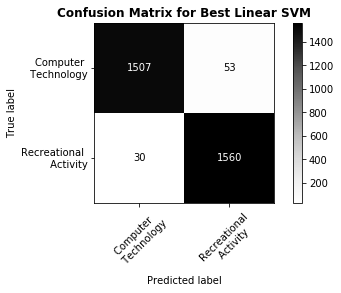

In [19]:
plot_confusion_matrix(svm_best, X_test_LSI, Y_test_binary, display_labels=class_names, 
                             values_format='d', xticks_rotation=45, cmap=plt.cm.Greys)
plt.tight_layout()
plt.title('Confusion Matrix for Best Linear SVM', fontweight='bold')
plt.show()
# plt.savefig('cm_best.png')

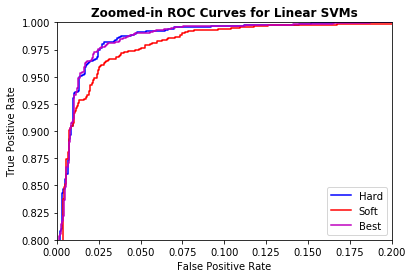

In [20]:
fpr_best, tpr_best, _ = roc_curve(Y_test_binary, Y_test_prob_best)

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_hard, tpr_hard, label = 'Hard', color = 'b')
plt.plot(fpr_soft, tpr_soft, label = 'Soft', color = 'r')
plt.plot(fpr_best, tpr_best, label = 'Best', color = 'm')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.xlim(0,0.2)
plt.ylim(0.8,1)
plt.title('Zoomed-in ROC Curves for Linear SVMs', fontweight="bold")
plt.show()
# plt.savefig('ROC_SVMs_details.png')

# Question 5: Logistic Regression

In [21]:
from sklearn.linear_model import LogisticRegression

# without regularization
logistic_raw = LogisticRegression(C=10**15, solver='newton-cg')
logistic_raw.fit(X_train_LSI, Y_train_binary)

Y_test_label_logistic = logistic_raw.predict(X_test_LSI)
Y_test_prob_logistic = logistic_raw.decision_function(X_test_LSI)

print('confusion_matrix:\n', confusion_matrix(Y_test_binary, Y_test_label_logistic))
print('accuracy:', accuracy_score(Y_test_binary, Y_test_label_logistic))
print('recall:', recall_score(Y_test_binary, Y_test_label_logistic))
print('precision:', precision_score(Y_test_binary, Y_test_label_logistic))
print('f1_score:', f1_score(Y_test_binary, Y_test_label_logistic))

confusion_matrix:
 [[1504   56]
 [  21 1569]]
accuracy: 0.9755555555555555
recall: 0.9867924528301887
precision: 0.9655384615384616
f1_score: 0.976049766718507


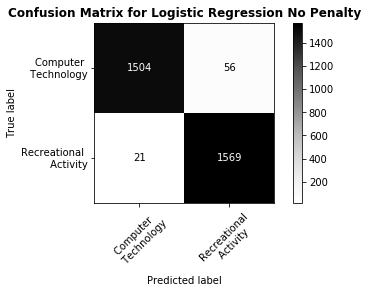

In [22]:
plot_confusion_matrix(logistic_raw, X_test_LSI, Y_test_binary, display_labels=class_names, 
                             values_format='d', xticks_rotation=45, cmap=plt.cm.Greys)
plt.tight_layout()
plt.title('Confusion Matrix for Logistic Regression No Penalty', fontweight='bold')
plt.show()
# plt.savefig('cm_lr_no.png')

In [23]:
# best logistic regression with l1 penalty 
logistic_l1_cv = GridSearchCV(estimator=LogisticRegression(penalty='l1', solver='liblinear'), 
                              param_grid={'C':[10**-3,10**-2,10**-1,10**0,10**1,10**2,10**3]}, cv=5)
logistic_l1_cv.fit(X_train_LSI, Y_train_binary)

pd.DataFrame(logistic_l1_cv.cv_results_)[['param_C','mean_test_score']]

,param_C,mean_test_score
0,0.001,0.495139
1,0.01,0.936601
2,0.1,0.950973
3,1,0.969779
4,10,0.978444
5,100,0.978866
6,1000,0.979289


In [24]:
logistic_l1_best = LogisticRegression(penalty='l1', C=logistic_l1_cv.best_params_['C'], solver='liblinear')
logistic_l1_best.fit(X_train_LSI, Y_train_binary)

Y_test_label_logisticl1 = logistic_l1_best.predict(X_test_LSI)
Y_test_prob_logisticl1 = logistic_l1_best.decision_function(X_test_LSI)

print('confusion_matrix:\n', confusion_matrix(Y_test_binary, Y_test_label_logisticl1))
print('accuracy:', accuracy_score(Y_test_binary, Y_test_label_logisticl1))
print('recall:', recall_score(Y_test_binary, Y_test_label_logisticl1))
print('precision:', precision_score(Y_test_binary, Y_test_label_logisticl1))
print('f1_score:', f1_score(Y_test_binary, Y_test_label_logisticl1))

confusion_matrix:
 [[1504   56]
 [  21 1569]]
accuracy: 0.9755555555555555
recall: 0.9867924528301887
precision: 0.9655384615384616
f1_score: 0.976049766718507


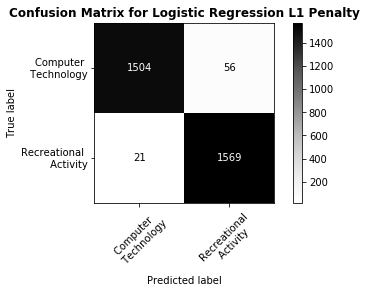

In [25]:
plot_confusion_matrix(logistic_l1_best, X_test_LSI, Y_test_binary, display_labels=class_names, 
                             values_format='d', xticks_rotation=45, cmap=plt.cm.Greys)
plt.tight_layout()
plt.title('Confusion Matrix for Logistic Regression L1 Penalty', fontweight='bold')
plt.show()
# plt.savefig('cm_lr_l1.png')

In [26]:
# best logistic regression with l2 penalty 

logistic_l2_cv = GridSearchCV(estimator=LogisticRegression(penalty='l2', solver='newton-cg'), 
                              param_grid={'C':[10**-3,10**-2,10**-1,10**0,10**1,10**2,10**3]}, cv=5)
logistic_l2_cv.fit(X_train_LSI, Y_train_binary)

pd.DataFrame(logistic_l2_cv.cv_results_)[['param_C','mean_test_score']]

,param_C,mean_test_score
0,0.001,0.543533
1,0.01,0.936392
2,0.1,0.962807
3,1,0.970413
4,10,0.977387
5,100,0.979500
6,1000,0.979923


In [27]:
logistic_l2_best = LogisticRegression(penalty='l2', C=logistic_l2_cv.best_params_['C'], solver='newton-cg')
logistic_l2_best.fit(X_train_LSI, Y_train_binary)

Y_test_label_logisticl2 = logistic_l2_best.predict(X_test_LSI)
Y_test_prob_logisticl2 = logistic_l2_best.decision_function(X_test_LSI)

print('confusion_matrix:\n', confusion_matrix(Y_test_binary, Y_test_label_logisticl2))
print('accuracy:', accuracy_score(Y_test_binary, Y_test_label_logisticl2))
print('recall:', recall_score(Y_test_binary, Y_test_label_logisticl2))
print('precision:', precision_score(Y_test_binary, Y_test_label_logisticl2))
print('f1_score:', f1_score(Y_test_binary, Y_test_label_logisticl2))

confusion_matrix:
 [[1505   55]
 [  23 1567]]
accuracy: 0.9752380952380952
recall: 0.9855345911949686
precision: 0.9660912453760789
f1_score: 0.9757160647571607


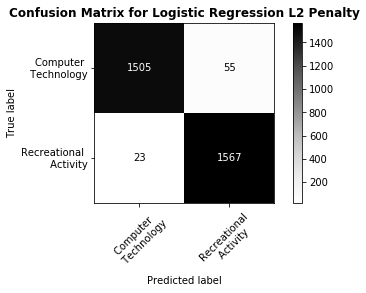

In [28]:
plot_confusion_matrix(logistic_l2_best, X_test_LSI, Y_test_binary, display_labels=class_names, 
                             values_format='d', xticks_rotation=45, cmap=plt.cm.Greys)
plt.tight_layout()
plt.title('Confusion Matrix for Logistic Regression L2 Penalty', fontweight='bold')
plt.show()
# plt.savefig('cm_lr_l2.png')

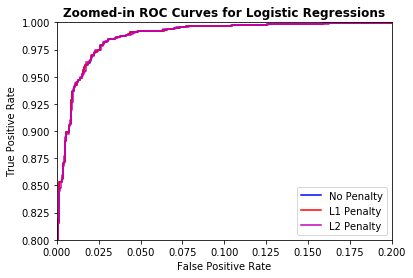

In [29]:
fpr_logistic, tpr_logistic, _ = roc_curve(Y_test_binary, Y_test_prob_logistic)
fpr_logisticl1, tpr_logisticl1, _ = roc_curve(Y_test_binary, Y_test_prob_logisticl1)
fpr_logisticl2, tpr_logisticl2, _ = roc_curve(Y_test_binary, Y_test_prob_logisticl2)

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_logistic, tpr_logistic, label = 'No Penalty', color = 'b')
plt.plot(fpr_logisticl1, tpr_logisticl1, label = 'L1 Penalty', color = 'r')
plt.plot(fpr_logisticl2, tpr_logisticl2, label = 'L2 Penalty', color = 'm')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Zoomed-in ROC Curves for Logistic Regressions', fontweight='bold')
plt.xlim(0,0.2)
plt.ylim(0.8,1)
plt.legend(loc='lower right')
plt.show()
# plt.savefig('ROC_LRs_detail.png')

# Question 6: Naive Bayes

In [30]:
from sklearn.naive_bayes import GaussianNB

gauss_nb = GaussianNB()
gauss_nb.fit(X_train_LSI, Y_train_binary)

Y_test_label_nb = gauss_nb.predict(X_test_LSI)
Y_test_prob_nb = gauss_nb.predict_proba(X_test_LSI)[:,1]


print('confusion_matrix:\n', confusion_matrix(Y_test_binary, Y_test_label_nb))
print('accuracy:', accuracy_score(Y_test_binary, Y_test_label_nb))
print('recall:', recall_score(Y_test_binary, Y_test_label_nb))
print('precision:', precision_score(Y_test_binary, Y_test_label_nb))
print('f1_score:', f1_score(Y_test_binary, Y_test_label_nb))

confusion_matrix:
 [[1084  476]
 [  37 1553]]
accuracy: 0.8371428571428572
recall: 0.9767295597484277
precision: 0.7654016757023164
f1_score: 0.8582481348438795


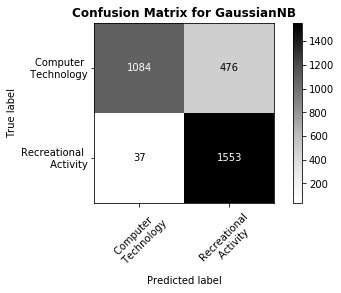

In [31]:
plot_confusion_matrix(gauss_nb, X_test_LSI, Y_test_binary, display_labels=class_names, 
                             values_format='d', xticks_rotation=45, cmap=plt.cm.Greys)
plt.tight_layout()
plt.title('Confusion Matrix for GaussianNB', fontweight='bold')
plt.show()
# plt.savefig('cm_gaussnb.png')

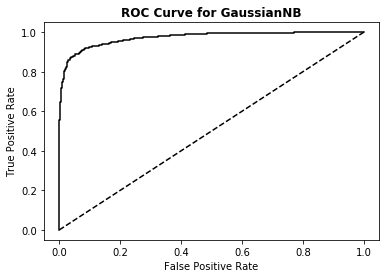

In [32]:
fpr_nb, tpr_nb, _ = roc_curve(Y_test_binary, Y_test_prob_nb)


plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_nb, tpr_nb, label = 'Naive Bayes', color = 'k')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for GaussianNB', fontweight='bold')
plt.show()
# plt.savefig('ROC_NB.png')

# Question 7: Grid Search of Parameters

In [33]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('vectorize', CountVectorizer(stop_words='english')),
    ('tfidf', TfidfTransformer()),
    ('reduce_dim', TruncatedSVD()),
    ('clf', SVC()),
])

parameters = [
    {
        'vectorize__min_df': [3,5],
        'reduce_dim': [TruncatedSVD(n_components=50), NMF(n_components=50)],
        'clf': [SVC(C=svm_cv.best_params_['C'], kernel='linear'), GaussianNB(),
               LogisticRegression(C=logistic_l1_best.C, penalty = 'l1', solver='liblinear'),
               LogisticRegression(C=logistic_l2_best.C, penalty = 'l2', solver='newton-cg')]
    }
]

In [34]:
# With Headers and Footers
grid1 = GridSearchCV(pipeline, cv=5, n_jobs=-1, param_grid = parameters, scoring='accuracy')
grid1.fit(train_dataset.data, Y_train_binary)
result_w_hf = pd.DataFrame(grid1.cv_results_)
result_w_hf['lemmatized'] = False
result_w_hf['with_headers_footers'] = True

grid2 = GridSearchCV(pipeline, cv=5, n_jobs=-1, param_grid = parameters, scoring='accuracy')
grid2.fit(train_dataset_lemmatized, Y_train_binary)
result_lemm_w_hf = pd.DataFrame(grid2.cv_results_)
result_lemm_w_hf['lemmatized'] = True
result_lemm_w_hf['with_headers_footers'] = True

# Without Headers and Footers
train_dataset_wo_hf = fetch_20newsgroups(subset = 'train', categories = categories, 
                                         remove = ('headers','footers'), shuffle = True, random_state = None)

Y_train_binary_wo_hf = np.zeros(train_dataset_wo_hf.target.shape)
Y_train_binary_wo_hf[train_dataset_wo_hf.target > 3] = 1


grid3 = GridSearchCV(pipeline, cv=5, n_jobs=-1, param_grid = parameters, scoring='accuracy')
grid3.fit(train_dataset_wo_hf.data, Y_train_binary_wo_hf)
result_wo_hf = pd.DataFrame(grid3.cv_results_)
result_wo_hf['lemmatized'] = False
result_wo_hf['with_headers_footers'] = False

grid4 = GridSearchCV(pipeline, cv=5, n_jobs=-1, param_grid = parameters, scoring='accuracy')
grid4.fit(lemmatize(train_dataset_wo_hf.data), Y_train_binary_wo_hf)
result_lemm_wo_hf = pd.DataFrame(grid4.cv_results_)
result_lemm_wo_hf['lemmatized'] = True
result_lemm_wo_hf['with_headers_footers'] = False

In [35]:
results = pd.concat([result_w_hf, result_lemm_w_hf, result_wo_hf, result_lemm_wo_hf])
results = results[['mean_test_score', 'param_clf', 'param_reduce_dim','param_vectorize__min_df',
                   'lemmatized', 'with_headers_footers']].sort_values(by=['mean_test_score'], ascending=False)
results = results.reset_index(drop=True)

In [36]:
pd.set_option('display.max_colwidth', -1)

In [37]:
results.head()

,mean_test_score,param_clf,param_reduce_dim,param_vectorize__min_df,lemmatized,with_headers_footers
0,0.977599,"SVC(C=100, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,\n decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',\n max_iter=-1, probability=False, random_state=None, shrinking=True,\n tol=0.001, verbose=False)","TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,\n random_state=None, tol=0.0)",3,True,True
1,0.977388,"LogisticRegression(C=1000, class_weight=None, dual=False, fit_intercept=True,\n intercept_scaling=1, l1_ratio=None, max_iter=100,\n multi_class='auto', n_jobs=None, penalty='l2',\n random_state=None, solver='newton-cg', tol=0.0001, verbose=0,\n warm_start=False)","TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,\n random_state=None, tol=0.0)",5,True,True
2,0.977387,"SVC(C=100, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,\n decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',\n max_iter=-1, probability=False, random_state=None, shrinking=True,\n tol=0.001, verbose=False)","TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,\n random_state=None, tol=0.0)",3,False,True
3,0.976965,"LogisticRegression(C=1000, class_weight=None, dual=False, fit_intercept=True,\n intercept_scaling=1, l1_ratio=None, max_iter=100,\n multi_class='auto', n_jobs=None, penalty='l1',\n random_state=None, solver='liblinear', tol=0.0001, verbose=0,\n warm_start=False)","TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,\n random_state=None, tol=0.0)",5,True,True
4,0.976330,"LogisticRegression(C=1000, class_weight=None, dual=False, fit_intercept=True,\n intercept_scaling=1, l1_ratio=None, max_iter=100,\n multi_class='auto', n_jobs=None, penalty='l1',\n random_state=None, solver='liblinear', tol=0.0001, verbose=0,\n warm_start=False)","TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,\n random_state=None, tol=0.0)",3,True,True


# Question 8: Multiclass Classification

In [38]:
mclass_categories = ['comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'misc.forsale', 'soc.religion.christian']

mclass_train_dataset = fetch_20newsgroups(subset = 'train', categories = mclass_categories, shuffle = True, random_state = None)
mclass_test_dataset = fetch_20newsgroups(subset = 'test', categories = mclass_categories, shuffle = True, random_state = None)

In [39]:
# lemmatization
mclass_train_dataset_lemmatized = lemmatize(mclass_train_dataset.data)
mclass_test_dataset_lemmatized = lemmatize(mclass_test_dataset.data)

# CountVectorizer
mclass_count = CountVectorizer(stop_words = 'english', min_df = 3)
mclass_X_train_count = mclass_count.fit_transform(mclass_train_dataset_lemmatized)
mclass_X_test_count = mclass_count.transform(mclass_test_dataset_lemmatized)

# TF-IDF
mclass_tfidf = TfidfTransformer()
mclass_X_train_tfidf = mclass_tfidf.fit_transform(mclass_X_train_count).toarray()
mclass_X_test_tfidf = mclass_tfidf.transform(mclass_X_test_count).toarray()

# LSI
mclass_lsi = TruncatedSVD(n_components = 50)
mclass_X_train_LSI = mclass_lsi.fit_transform(mclass_X_train_tfidf)
mclass_X_test_LSI = mclass_lsi.transform(mclass_X_test_tfidf)

# NMF
mclass_nmf = NMF(n_components=50)
mclass_X_train_NMF = mclass_nmf.fit_transform(mclass_X_train_tfidf)
mclass_X_test_NMF = mclass_nmf.transform(mclass_X_test_tfidf)

confusion_matrix:
 [[290  58  38   6]
 [ 52 284  44   5]
 [ 48  59 267  16]
 [  3   5   4 386]]
accuracy: 0.7840255591054313
recall: 0.7829807217190562
precision: 0.7821048775453165
f1_score: 0.7818877616189237


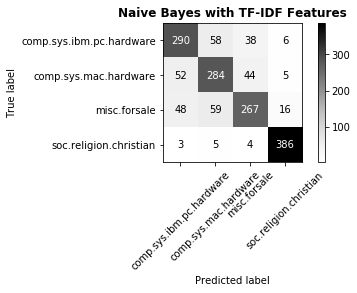

In [40]:
# Naive Bayes with TF-IDF
mclass_gauss_nb = GaussianNB()
mclass_gauss_nb.fit(mclass_X_train_tfidf, mclass_train_dataset.target)
mclass_Y_test_pred_nb = mclass_gauss_nb.predict(mclass_X_test_tfidf)

print('confusion_matrix:\n', confusion_matrix(mclass_test_dataset.target, mclass_Y_test_pred_nb))
print('accuracy:', accuracy_score(mclass_test_dataset.target, mclass_Y_test_pred_nb))
print('recall:', recall_score(mclass_test_dataset.target, mclass_Y_test_pred_nb, average='macro'))
print('precision:', precision_score(mclass_test_dataset.target, mclass_Y_test_pred_nb, average='macro'))
print('f1_score:', f1_score(mclass_test_dataset.target, mclass_Y_test_pred_nb, average='macro'))

plot_confusion_matrix(mclass_gauss_nb, mclass_X_test_tfidf, mclass_test_dataset.target, display_labels=mclass_categories, 
                             values_format='d', xticks_rotation=45, cmap=plt.cm.Greys)
plt.tight_layout()
plt.title('Naive Bayes with TF-IDF Features', fontweight='bold')
plt.show()

confusion_matrix:
 [[217  35 132   8]
 [ 72 156 151   6]
 [ 54  20 308   8]
 [  0   0   6 392]]
accuracy: 0.6856230031948882
recall: 0.6833586116563504
precision: 0.7086905888298933
f1_score: 0.675899209979678


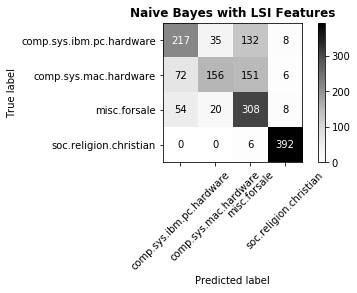

In [41]:
# Naive Bayes with LSI
mclass_gauss_nb = GaussianNB()
mclass_gauss_nb.fit(mclass_X_train_LSI, mclass_train_dataset.target)
mclass_Y_test_pred_nb = mclass_gauss_nb.predict(mclass_X_test_LSI)

print('confusion_matrix:\n', confusion_matrix(mclass_test_dataset.target, mclass_Y_test_pred_nb))
print('accuracy:', accuracy_score(mclass_test_dataset.target, mclass_Y_test_pred_nb))
print('recall:', recall_score(mclass_test_dataset.target, mclass_Y_test_pred_nb, average='macro'))
print('precision:', precision_score(mclass_test_dataset.target, mclass_Y_test_pred_nb, average='macro'))
print('f1_score:', f1_score(mclass_test_dataset.target, mclass_Y_test_pred_nb, average='macro'))

plot_confusion_matrix(mclass_gauss_nb, mclass_X_test_LSI, mclass_test_dataset.target, display_labels=mclass_categories, 
                             values_format='d', xticks_rotation=45, cmap=plt.cm.Greys)
plt.tight_layout()
plt.title('Naive Bayes with LSI Features', fontweight='bold')
plt.show()

confusion_matrix:
 [[277  33  75   7]
 [ 54 246  82   3]
 [ 47  24 301  18]
 [  2   0   3 393]]
accuracy: 0.7776357827476038
recall: 0.7762064374366959
precision: 0.7818121648716432
f1_score: 0.7749607185791876


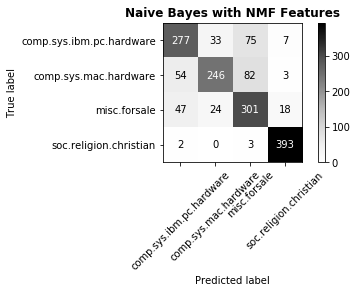

In [42]:
# Naive Bayes with NMF
mclass_gauss_nb = GaussianNB()
mclass_gauss_nb.fit(mclass_X_train_NMF, mclass_train_dataset.target)
mclass_Y_test_pred_nb = mclass_gauss_nb.predict(mclass_X_test_NMF)

print('confusion_matrix:\n', confusion_matrix(mclass_test_dataset.target, mclass_Y_test_pred_nb))
print('accuracy:', accuracy_score(mclass_test_dataset.target, mclass_Y_test_pred_nb))
print('recall:', recall_score(mclass_test_dataset.target, mclass_Y_test_pred_nb, average='macro'))
print('precision:', precision_score(mclass_test_dataset.target, mclass_Y_test_pred_nb, average='macro'))
print('f1_score:', f1_score(mclass_test_dataset.target, mclass_Y_test_pred_nb, average='macro'))

plot_confusion_matrix(mclass_gauss_nb, mclass_X_test_NMF, mclass_test_dataset.target, display_labels=mclass_categories, 
                             values_format='d', xticks_rotation=45, cmap=plt.cm.Greys)
plt.tight_layout()
plt.title('Naive Bayes with NMF Features', fontweight='bold')
plt.show()

confusion_matrix:
 [[344  25  23   0]
 [ 37 333  14   1]
 [ 17  12 359   2]
 [  5   1   4 388]]
accuracy: 0.9099041533546326
recall: 0.9094683194288362
precision: 0.910249876151614
f1_score: 0.9096863482198181


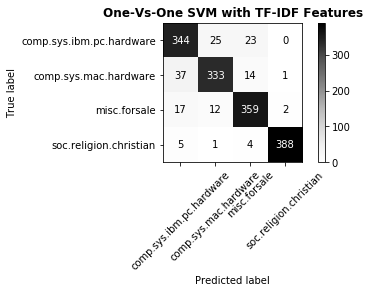

In [43]:
# One-Vs-One Linear SVM with TF-IDF
from sklearn.multiclass import OneVsOneClassifier

mclass_svm_ovo = OneVsOneClassifier(SVC(kernel='linear'))
mclass_svm_ovo.fit(mclass_X_train_tfidf, mclass_train_dataset.target)
mclass_Y_test_pred_ovo = mclass_svm_ovo.predict(mclass_X_test_tfidf)

print('confusion_matrix:\n', confusion_matrix(mclass_test_dataset.target, mclass_Y_test_pred_ovo))
print('accuracy:', accuracy_score(mclass_test_dataset.target, mclass_Y_test_pred_ovo))
print('recall:', recall_score(mclass_test_dataset.target, mclass_Y_test_pred_ovo, average='macro'))
print('precision:', precision_score(mclass_test_dataset.target, mclass_Y_test_pred_ovo, average='macro'))
print('f1_score:', f1_score(mclass_test_dataset.target, mclass_Y_test_pred_ovo, average='macro'))

plot_confusion_matrix(mclass_svm_ovo, mclass_X_test_tfidf, mclass_test_dataset.target, display_labels=mclass_categories, 
                             values_format='d', xticks_rotation=45, cmap=plt.cm.Greys)
plt.tight_layout()
plt.title('One-Vs-One SVM with TF-IDF Features', fontweight='bold')
plt.show()

confusion_matrix:
 [[348  27  17   0]
 [ 67 299  18   1]
 [ 29  13 346   2]
 [  8   1   6 383]]
accuracy: 0.8792332268370607
recall: 0.8784673809081562
precision: 0.8839020239876231
f1_score: 0.8792794607253377


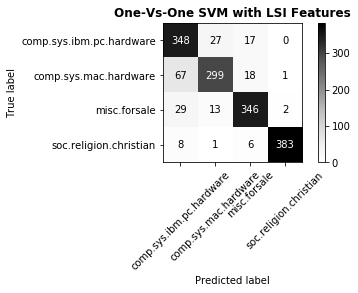

In [44]:
# One-Vs-One Linear SVM with LSI

mclass_svm_ovo = OneVsOneClassifier(SVC(kernel='linear'))
mclass_svm_ovo.fit(mclass_X_train_LSI, mclass_train_dataset.target)
mclass_Y_test_pred_ovo = mclass_svm_ovo.predict(mclass_X_test_LSI)

print('confusion_matrix:\n', confusion_matrix(mclass_test_dataset.target, mclass_Y_test_pred_ovo))
print('accuracy:', accuracy_score(mclass_test_dataset.target, mclass_Y_test_pred_ovo))
print('recall:', recall_score(mclass_test_dataset.target, mclass_Y_test_pred_ovo, average='macro'))
print('precision:', precision_score(mclass_test_dataset.target, mclass_Y_test_pred_ovo, average='macro'))
print('f1_score:', f1_score(mclass_test_dataset.target, mclass_Y_test_pred_ovo, average='macro'))

plot_confusion_matrix(mclass_svm_ovo, mclass_X_test_LSI, mclass_test_dataset.target, display_labels=mclass_categories, 
                             values_format='d', xticks_rotation=45, cmap=plt.cm.Greys)
plt.tight_layout()
plt.title('One-Vs-One SVM with LSI Features', fontweight='bold')
plt.show()

confusion_matrix:
 [[358  13  21   0]
 [115 247  22   1]
 [ 82  11 293   4]
 [ 19   0   6 373]]
accuracy: 0.8121405750798723
recall: 0.8108229321527958
precision: 0.8446575317883505
f1_score: 0.8140340657295384


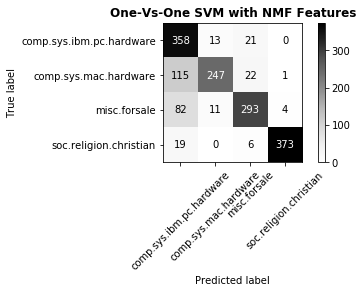

In [45]:
# One-Vs-One Linear SVM with NMF

mclass_svm_ovo = OneVsOneClassifier(SVC(kernel='linear'))
mclass_svm_ovo.fit(mclass_X_train_NMF, mclass_train_dataset.target)
mclass_Y_test_pred_ovo = mclass_svm_ovo.predict(mclass_X_test_NMF)

print('confusion_matrix:\n', confusion_matrix(mclass_test_dataset.target, mclass_Y_test_pred_ovo))
print('accuracy:', accuracy_score(mclass_test_dataset.target, mclass_Y_test_pred_ovo))
print('recall:', recall_score(mclass_test_dataset.target, mclass_Y_test_pred_ovo, average='macro'))
print('precision:', precision_score(mclass_test_dataset.target, mclass_Y_test_pred_ovo, average='macro'))
print('f1_score:', f1_score(mclass_test_dataset.target, mclass_Y_test_pred_ovo, average='macro'))

plot_confusion_matrix(mclass_svm_ovo, mclass_X_test_NMF, mclass_test_dataset.target, display_labels=mclass_categories, 
                             values_format='d', xticks_rotation=45, cmap=plt.cm.Greys)
plt.tight_layout()
plt.title('One-Vs-One SVM with NMF Features', fontweight='bold')
plt.show()

confusion_matrix:
 [[342  29  20   1]
 [ 31 338  14   2]
 [ 13  13 362   2]
 [  3   0   3 392]]
accuracy: 0.91629392971246
recall: 0.9158752022086551
precision: 0.9158311935225838
f1_score: 0.9158102864555878


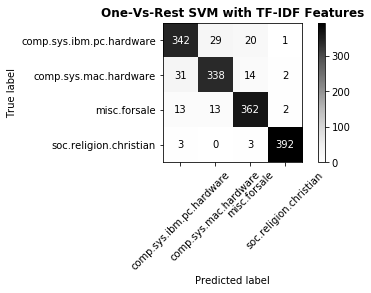

In [46]:
# One-Vs-Rest Linear SVM with TF-IDF
from sklearn.multiclass import OneVsRestClassifier

mclass_svm_ovr = OneVsRestClassifier(SVC(kernel='linear'))
mclass_svm_ovr.fit(mclass_X_train_tfidf, mclass_train_dataset.target)
mclass_Y_test_pred_ovr = mclass_svm_ovr.predict(mclass_X_test_tfidf)

print('confusion_matrix:\n', confusion_matrix(mclass_test_dataset.target, mclass_Y_test_pred_ovr))
print('accuracy:', accuracy_score(mclass_test_dataset.target, mclass_Y_test_pred_ovr))
print('recall:', recall_score(mclass_test_dataset.target, mclass_Y_test_pred_ovr, average='macro'))
print('precision:', precision_score(mclass_test_dataset.target, mclass_Y_test_pred_ovr, average='macro'))
print('f1_score:', f1_score(mclass_test_dataset.target, mclass_Y_test_pred_ovr, average='macro'))

plot_confusion_matrix(mclass_svm_ovr, mclass_X_test_tfidf, mclass_test_dataset.target, display_labels=mclass_categories, 
                             values_format='d', xticks_rotation=45, cmap=plt.cm.Greys)
plt.tight_layout()
plt.title('One-Vs-Rest SVM with TF-IDF Features', fontweight='bold')
plt.show()

confusion_matrix:
 [[330  40  21   1]
 [ 52 306  22   5]
 [ 20  12 350   8]
 [  3   0   1 394]]
accuracy: 0.8817891373801917
recall: 0.881006893919672
precision: 0.8808936414432552
f1_score: 0.8805794460602764


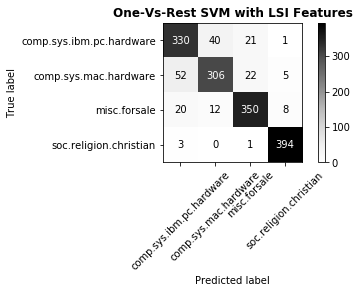

In [47]:
# One-Vs-Rest Linear SVM with LSI

mclass_svm_ovr = OneVsRestClassifier(SVC(kernel='linear'))
mclass_svm_ovr.fit(mclass_X_train_LSI, mclass_train_dataset.target)
mclass_Y_test_pred_ovr = mclass_svm_ovr.predict(mclass_X_test_LSI)

print('confusion_matrix:\n', confusion_matrix(mclass_test_dataset.target, mclass_Y_test_pred_ovr))
print('accuracy:', accuracy_score(mclass_test_dataset.target, mclass_Y_test_pred_ovr))
print('recall:', recall_score(mclass_test_dataset.target, mclass_Y_test_pred_ovr, average='macro'))
print('precision:', precision_score(mclass_test_dataset.target, mclass_Y_test_pred_ovr, average='macro'))
print('f1_score:', f1_score(mclass_test_dataset.target, mclass_Y_test_pred_ovr, average='macro'))

plot_confusion_matrix(mclass_svm_ovr, mclass_X_test_LSI, mclass_test_dataset.target, display_labels=mclass_categories, 
                             values_format='d', xticks_rotation=45, cmap=plt.cm.Greys)
plt.tight_layout()
plt.title('One-Vs-Rest SVM with LSI Features', fontweight='bold')
plt.show()

confusion_matrix:
 [[282  54  33  23]
 [ 47 301  20  17]
 [ 26  16 330  18]
 [  0   0   3 395]]
accuracy: 0.8357827476038339
recall: 0.8349555236579644
precision: 0.8331434779011315
f1_score: 0.8325378661267263


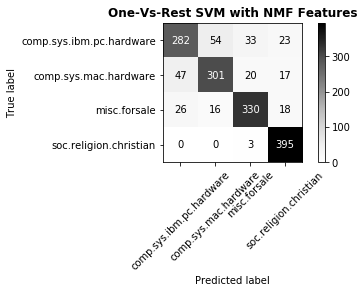

In [48]:
# One-Vs-Rest Linear SVM with NMF

mclass_svm_ovr = OneVsRestClassifier(SVC(kernel='linear'))
mclass_svm_ovr.fit(mclass_X_train_NMF, mclass_train_dataset.target)
mclass_Y_test_pred_ovr = mclass_svm_ovr.predict(mclass_X_test_NMF)

print('confusion_matrix:\n', confusion_matrix(mclass_test_dataset.target, mclass_Y_test_pred_ovr))
print('accuracy:', accuracy_score(mclass_test_dataset.target, mclass_Y_test_pred_ovr))
print('recall:', recall_score(mclass_test_dataset.target, mclass_Y_test_pred_ovr, average='macro'))
print('precision:', precision_score(mclass_test_dataset.target, mclass_Y_test_pred_ovr, average='macro'))
print('f1_score:', f1_score(mclass_test_dataset.target, mclass_Y_test_pred_ovr, average='macro'))

plot_confusion_matrix(mclass_svm_ovr, mclass_X_test_NMF, mclass_test_dataset.target, display_labels=mclass_categories, 
                             values_format='d', xticks_rotation=45, cmap=plt.cm.Greys)
plt.tight_layout()
plt.title('One-Vs-Rest SVM with NMF Features', fontweight='bold')
plt.show()